In [43]:
import numpy as np
import pandas as pd

import random
from datetime import datetime

from sklearn.datasets import fetch_openml
from gtda.images import Binarizer, RadialFiltration, HeightFiltration
from gtda.homology import CubicalPersistence

import warnings

import warnings
from itertools import combinations
from ismember import ismember


from src.utils import cubical_complex
# from src.perslap import compute_pers_lap_pair

In [6]:
def load_data():
    # Full dataset is 60,000 train, 10,000 test
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
    # train_size, test_size = 6000, 1000

    # Reshape to (n_samples, n_pixels_x, n_pixels_y)
    X = X.reshape((-1, 28, 28))
    random.seed(42)
    idx = random.sample(range(len(X)), 7000)
    X = X[idx]
    y = y[idx]

    return X, y

X, y = load_data()

/home/siroj/miniconda3/envs/thesis/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [33]:
def boundary(SC, k, sort=False, complex_type='simplicial'):
    # Boundary - compute the boundary of a simplicial complex sc at dim k>=0
    if complex_type == 'cubical':
        assert (k < 3), 'Requested Laplacian of dim >2, can only compute up to 2.'

    # init boundary matrix
    n_k = len(SC[k])

    if k == 0:
        return np.zeros((n_k, n_k))
    if n_k == 0:
        n_km1 = len(SC[k-1])
        return np.zeros((n_km1, n_km1))

    Sk = SC[k]      # k-simplices
    Skm1 = SC[k-1]  # (k-1)-simplices

    if sort:
        Sk = np.sort(Sk, axis=1)
        Skm1 = np.sort(Skm1, axis=1)

    n_km1 = len(SC[k - 1])
    B = np.zeros((n_km1, n_k))

    # compute boundary matrix
    # for each column in Sk

    if complex_type == 'cubical':

        num_nodes = [1, 2, 4, 8]
        num_remove = [0, 1, 2, 4]
        correct_error_count = [0, 0, 2]

    elif complex_type == 'simplicial':
        num_nodes = [1, 2, 3, 4]
        num_remove = [0, 1, 1, 1]
        correct_error_count = [0, 0, 0, 0]

    else:
        raise ValueError('Unknown complex type specified')

    error_count = np.zeros(n_k)
    sign_count = np.zeros(n_k)

    for comb in combinations(range(num_nodes[k]), num_remove[k]):
        comb = list(comb)

        # remove ith column from Sk
        remove_col_ind = list(range(num_nodes[k]))
        for c in comb:
            remove_col_ind.remove(c)

        B_aux = Sk[:, remove_col_ind]

        # find rows of B_aux in S_(k-1)
        truth_array, ind = ismember(B_aux, Skm1, 'rows')

        for j in range(n_k):
            if truth_array[j]:
                if len(ind) != len(truth_array):
                    print(Sk)
                    print(B_aux, Skm1)
                    raise ValueError('Incorrectly specified simplicial complex')

                B[ind[j], j] = (-1)**(sign_count[j]-1)
                sign_count[j] += 1
                # B[ind[j], j] += (-1)**(sign_count[j]-1)  # for delta complexes
            else:
                error_count[j] += 1

    for err in error_count:
        if err != correct_error_count[k]:
            raise ValueError('Incorrectly specified' + complex_type + 'complex')

    return B

In [27]:
direction_list = [[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]]

center_or_dir = direction_list[0]
filtration_fitter = HeightFiltration(direction=np.array(center_or_dir))

resolution = 5

binarizer = Binarizer(threshold=0.4)
for id, (image, label) in enumerate(zip(X, y)):

    image_binarised = binarizer.fit_transform(image[None, :, :])
    filtration = filtration_fitter.fit_transform(image_binarised)

    # filtrations.append(filtration)
    # df = df.append({'id': id, 'label': label}, ignore_index=True)
    max_val = np.max(filtration)
    min_val = np.min(filtration)
    increment = (max_val - min_val) / resolution

    vals = [min_val + i * increment for i in range(resolution)]
    vals[-1] = max_val
    break

In [48]:
q=1
k = vals[2]
K = cubical_complex(filtration, k)

complex_type = 'cubical'  # or 'simplicial'
B_K_q = boundary(K, q, complex_type=complex_type)
B_K_q

array([[ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0., -1., -1.]])

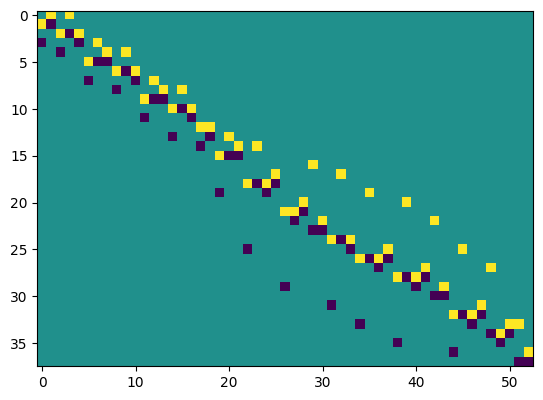

In [49]:
plt.imshow(B_K_q)

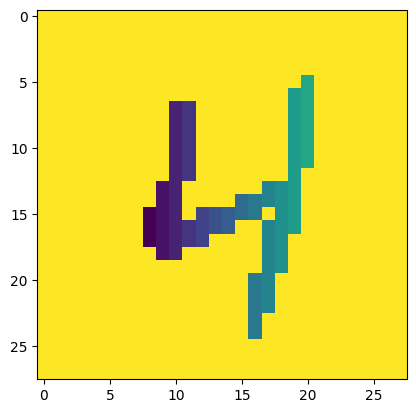

In [22]:
import matplotlib.pyplot as plt
plt.imshow(filtration[0])

In [23]:
cubical_persistence = CubicalPersistence(n_jobs=8)
diagrams = cubical_persistence.fit_transform(filtration)

In [25]:
diagrams

array([[[16., 17.,  0.],
        [18., 28.,  1.]]])